# Collaborative Filtering

After preprocessing, the process for creating a User Based recommendation system is as follows:
- Select a user with the movies the user has watched
- Based on his rating to movies, find the top X neighbours
- Get the watched movie record of the user for each neighbour.
- Calculate a similarity score using some formula
- Recommend the items with the highest score

In [1]:
import numpy as np
import pandas as pd
from django.db.models import Case, When

# Load data

In [2]:
movie_rating = pd.read_csv('movie_rating.csv')
movies = pd.read_csv('movies.csv')

# Preprocessing

# List Movies dataframe

In [3]:
movies = movies.drop('genre', 1) # remove colomn genre
movies = movies.drop('movie_logo', 1) # remove column movie_logo
movies.head()

/var/folders/68/blzwc4sd2w125pjz50zhv3sw0000gp/T/ipykernel_2539/2678615679.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  movies = movies.drop('genre', 1) # remove colomn genre
/var/folders/68/blzwc4sd2w125pjz50zhv3sw0000gp/T/ipykernel_2539/2678615679.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  movies = movies.drop('movie_logo', 1) # remove column movie_logo


,id,title
0,18,12 Angry Men
1,19,12 Years a Slave
2,20,A Beautiful Mind
3,21,Avatar
4,22,Avengers: Infinity War


In [4]:
# Merge movie with rating

In [5]:
# df = pd.merge(rate,movies,on='movie_id')
# df.head()

# Movie Rating

In [6]:
movie_rating = pd.read_csv('movie_rating.csv')
movie_rating.head()

,id,user_id,movie_id,rating
0,270,14,21,5
1,271,15,21,3
2,272,15,34,3
3,273,15,23,5
4,276,14,23,2


# Group up the rows by user ID.

In [7]:
#Groupby creates several sub dataframes where they all have the same value in the column specified as the parameter
user_group_rating = movie_rating.groupby('user_id')
user_group_rating.head()

,id,user_id,movie_id,rating
0,270,14,21,5
1,271,15,21,3
2,272,15,34,3
3,273,15,23,5
4,276,14,23,2
5,277,16,54,5


lets look at one of the users, e.g. the one with user logged_in

In [8]:
current_user_logged_in = 15
user_group_rating.get_group(current_user_logged_in)

,id,user_id,movie_id,rating
1,271,15,21,3
2,272,15,34,3
3,273,15,23,5


Let's also sort these groups so the users that share the most movies in common with the input have higher priority. This provides a richer recommendation since we won't go through every single user.

In [9]:
#Sorting it so users with movie most in common with the input will have priority
userSubsetGroup = sorted(user_group_rating,  key=lambda x: len(x[1]), reverse=True)

In [10]:

#Top most user with id 75 having all 5 similar moves watched
userSubsetGroup[0]

(15,
     id  user_id  movie_id  rating
 1  271       15        21       3
 2  272       15        34       3
 3  273       15        23       5)

In [11]:
#name of top user group
userSubsetGroup[0][0]

15

In [12]:

#dataframe of top user group
userSubsetGroup[0][1]

,id,user_id,movie_id,rating
1,271,15,21,3
2,272,15,34,3
3,273,15,23,5


# Similarity of users to input user
Next, we are going to compare all users (not really all !!!) to our specified user and find the one that is most similar.
we're going to find out how similar each user is to the input through the Pearson Correlation Coefficient. It is used to measure the strength of a linear association between two variables. The formula for finding this coefficient between sets X and Y with N values can be seen in the image below.

Why Pearson Correlation?

Pearson correlation is invariant to scaling, i.e. multiplying all elements by a nonzero constant or adding any constant to all elements. For example, if you have two vectors X and Y,then, pearson(X, Y) == pearson(X, 2 * Y + 3). This is a pretty important property in recommendation systems because for example two users might rate two series of items totally different in terms of absolute rates, but they would be similar users (i.e. with similar ideas) with similar rates in various scales .

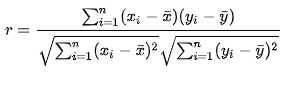

We will select a subset of users to iterate through. This limit is imposed because we don't want to waste too much time going through every single user.

In [13]:
userSubsetGroup = userSubsetGroup[0:100] # limit 100
userSubsetGroup

[(15,
      id  user_id  movie_id  rating
  1  271       15        21       3
  2  272       15        34       3
  3  273       15        23       5),
 (14,
      id  user_id  movie_id  rating
  0  270       14        21       5
  4  276       14        23       2),
 (16,
      id  user_id  movie_id  rating
  5  277       16        54       5)]

Now, we calculate the Pearson Correlation between input user and subset group, and store it in a dictionary, where the key is the user Id and the value is the coefficient

In [14]:
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorrelationDict = {}

#For every user group in our subset
for name, group in userSubsetGroup:
    
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='movie_id')
    inputMovies = movie_rating.sort_values(by='movie_id')
    
    #Get the N (total similar movies watched) for the formula 
    nRatings = len(group)
    
    #Get the review scores for the movies that they both have in common
    temp_df = movie_rating[movie_rating['movie_id'].isin(group['movie_id'].tolist())]
    
    ###For Debugging Purpose
    #if nRatings<5:
    #    print(inputMovies['movieId'].isin(group['movieId'].tolist()))
    #    break
    #else:
    #    continue
    
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    tempRatingList = temp_df['rating'].tolist()
    
    #Let's also put the current user group reviews in a list format
    tempGroupList = group['rating'].tolist()
    
    #Now let's calculate the pearson correlation between two users, so called, x and y

    #For package based
    # scipy.stats import pearsonr
    # pearsonr(tempRatingList,tempGroupList)[0]
    

    #For hard code based
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/ np.sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0

/var/folders/68/blzwc4sd2w125pjz50zhv3sw0000gp/T/ipykernel_2539/321653637.py:44: RuntimeWarning: invalid value encountered in sqrt
  pearsonCorrelationDict[name] = Sxy/ np.sqrt(Sxx*Syy)


In [15]:
pearsonCorrelationDict.items()

dict_items([(15, nan), (14, nan), (16, 0)])

In [16]:

pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.head()

,0
15,NaN
14,NaN
16,0.0


In [17]:
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,NaN,15
1,NaN,14
2,0.0,16


# The top x similar users to input user
Now let's get the top 1000 users that are most similar to the input.

In [18]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
2,0.0,16
0,NaN,15
1,NaN,14


# Rating of selected users to all movies
We're going to do this by taking the weighted average of the ratings of the movies using the Pearson Correlation as the weight. But to do this, we first need to get the movies watched by the users in our pearsonDF from the ratings dataframe and then store their correlation in a new column called _similarityIndex". This is achieved below by merging of these two tables.

In [19]:
movie_rating.head()
topUsersRating = topUsers.merge(movie_rating, left_on='userId', right_on='user_id')
# # topUsersRating = topUsers.merge(movie_rating, how='inner')
topUsersRating.head()

,similarityIndex,userId,id,user_id,movie_id,rating
0,0.0,16,277,16,54,5
1,NaN,15,271,15,21,3
2,NaN,15,272,15,34,3
3,NaN,15,273,15,23,5
4,NaN,14,270,14,21,5


Now all we need to do is simply multiply the movie rating by its weight (The similarity index), then sum up the new ratings and divide it by the sum of the weights.

We can easily do this by simply multiplying two columns, then grouping up the dataframe by movieId and then dividing two columns:

It shows the idea of all similar users to candidate movies for the input user:

In [20]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
topUsersRating.head()

,similarityIndex,userId,id,user_id,movie_id,rating,weightedRating
0,0.0,16,277,16,54,5,0.0
1,NaN,15,271,15,21,3,NaN
2,NaN,15,272,15,34,3,NaN
3,NaN,15,273,15,23,5,NaN
4,NaN,14,270,14,21,5,NaN


In [21]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('movie_id').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

,sum_similarityIndex,sum_weightedRating
movie_id,,
21,0.0,0.0
23,0.0,0.0
34,0.0,0.0
54,0.0,0.0


In [22]:

#Creates an empty dataframe
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()


,weighted average recommendation score,movieId
movie_id,,
21,NaN,21
23,NaN,23
34,NaN,34
54,NaN,54


# Recommended movies
Now let's sort it and see the top 20 movies that the algorithm recommended!

In [23]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head()

,weighted average recommendation score,movieId
movie_id,,
21,NaN,21
23,NaN,23
34,NaN,34
54,NaN,54


In [24]:

movies.loc[movies['id'].isin(recommendation_df.head(20)['movieId'].tolist())]

,id,title
3,21,Avatar
5,23,Avengers: Endgame
16,34,Frozen
36,54,The Shawshank Redemption


In [25]:




userRatings = movie_rating.pivot_table(index=['user_id'],columns=['movie_id'],values='rating')
userRatings.head()

movie_id,21,23,34,54
user_id,,,,
14,5.0,2.0,NaN,NaN
15,3.0,5.0,3.0,NaN
16,NaN,NaN,NaN,5.0


# Replace value NaN to 0.0

In [26]:
userRatings = userRatings.fillna(0,axis=1) # replace value NaN to 0
userRatings.head()

movie_id,21,23,34,54
user_id,,,,
14,5.0,2.0,0.0,0.0
15,3.0,5.0,3.0,0.0
16,0.0,0.0,0.0,5.0


# Corr Matrix

In [27]:
corrMatrix = userRatings.corr(method='pearson')
corrMatrix.head()

movie_id,21,23,34,54
movie_id,,,,
21,1.000000,0.500000,0.114708,-0.917663
23,0.500000,1.000000,0.917663,-0.802955
34,0.114708,0.917663,1.000000,-0.500000
54,-0.917663,-0.802955,-0.500000,1.000000


# My rating movie 

In [28]:
user = pd.read_csv('Myrating.csv')
user.head()

,movie_id,rating
0,21,5
1,23,2


# User filtered

In [29]:
user_filtered = [tuple(x) for x in user.values]
print(user_filtered)

[(21, 5), (23, 2)]


# Movie ID Watched

In [30]:
movie_id_watched = [each[0] for each in user_filtered]
print(movie_id_watched)

[21, 23]


# Get similar

In [31]:
def get_similar(movie_id,rating,corrMatrix):
    #print(f'############### func get_similar() movie_id:{movie_id} ###################')
    # corrMatrix value::
        # movie_id  19   21   23
        # movie_id
        # 19       NaN  NaN  NaN
        # 21       NaN  1.0  0.5
        # 23       NaN  0.5  1.0

    # (movie_id, rating) value: (21, 4)

    #print(f'corrMatrix[movie_id]: {movie_id}')
    #print(corrMatrix[movie_id])
    #output:
        # corrMatrix[movie_id]: 21
        # movie_id
        # 19    NaN
        # 21    1.0
        # 23    0.5
        # Name: 21, dtype: float64

    similar_ratings = corrMatrix[movie_id]*(rating-2.5)
    #print(f'--------- similar_ratings movie_id:{movie_id} --------------', similar_ratings, sep="\n")
    #output: 
        # movie_id
        # 19     NaN
        # 21    1.50
        # 23    0.75
        # Name: 21, dtype: float64

    similar_ratings = similar_ratings.sort_values(ascending=False) # sort as DESC
    #print(f'--------- similar_ratings sort_values movie_id:{movie_id} --------------', similar_ratings, sep="\n")
    # output:
        # movie_id
        # 21    1.50
        # 23    0.75
        # 19     NaN
        # Name: 21, dtype: float64

    return similar_ratings

In [32]:
similar_movies = pd.DataFrame()
for movie,rating in user_filtered:
    similar_movies = similar_movies.append(get_similar(movie,rating,corrMatrix),ignore_index = True)

print(similar_movies)

movie_id    21    23        34        54
0         2.50  1.25  0.286770 -2.294157
1        -0.25 -0.50 -0.458831  0.401478


/var/folders/68/blzwc4sd2w125pjz50zhv3sw0000gp/T/ipykernel_2539/1850976054.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  similar_movies = similar_movies.append(get_similar(movie,rating,corrMatrix),ignore_index = True)


In [33]:
movies_id = list(similar_movies.sum().sort_values(ascending=False).index)
print(movies_id)

[21, 23, 34, 54]


# My Recommended movie result:

In [34]:
movies_id_recommend = [each for each in movies_id if each not in movie_id_watched]
# print(movies_id_recommend)
    
# filter movie title by id
if len(movies_id_recommend) > 0:
    recommended = movies[movies['id'].isin(movies_id_recommend)] 
    print('\nResult recommended :\n', recommended)


Result recommended :
     id                     title
16  34                    Frozen
36  54  The Shawshank Redemption
